In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time

In [2]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [3]:
model = HamiltonianMappingModel(targetPotential=isoDiskPotential, input_dim=2, hidden_dim=128, num_layers=64)
model.flow = model.flow.double()

In [4]:
n_actions = 20
n_angles = 1000
r_min = 0.25
r_max = 1.25
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=2*np.pi, n_steps=n_angles, r_bounds=[r_min,r_max]) #

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1787554983.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.scatter(*training_data.T, s=10)



Text(0.5, 1.0, 'Toy Orbits')

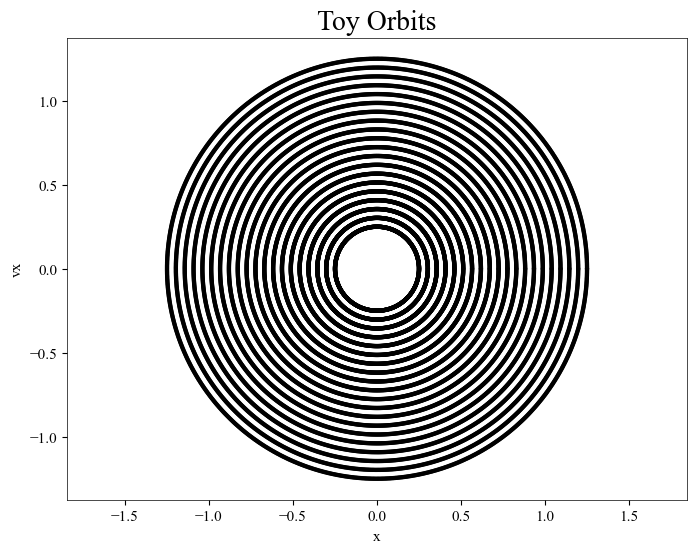

In [5]:
plt.scatter(*training_data.T, s=10)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

In [6]:
steps = 1000
model.train(training_data.to(torch.float64), steps, lr=1e-3)

100%|██████████| 1000/1000 [22:45<00:00,  1.37s/it] 


In [2]:
for i in range(20):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'loss')

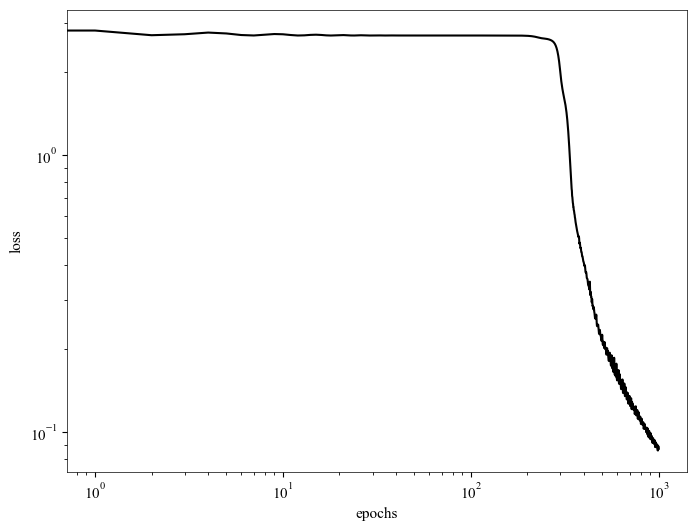

In [ ]:
plt.loglog(model.loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [8]:
aa_guess = aa_guess.to(torch.float64)
training_data = training_data.to(torch.float64)

Text(0.5, 1.0, 'model performance')

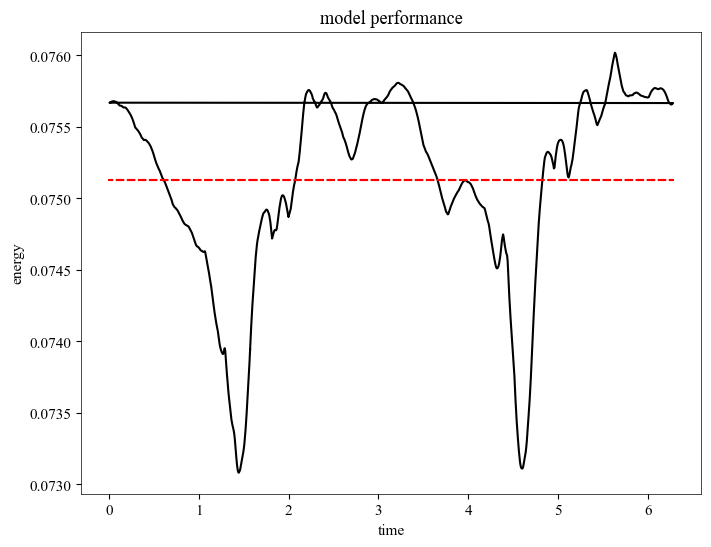

In [9]:
plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
plt.xlabel('time')
plt.ylabel('energy')
plt.title('model performance')

In [145]:
theta_set_arg = np.argmin(np.abs(model.hamiltonian(aa_guess[1]).detach() - np.repeat(model.hamiltonian(aa_guess[1]).mean().detach(), len(aa_guess[1][...,0].detach()))).numpy())
theta_set = aa_guess[7][theta_set_arg]

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/2732381563.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta_set_arg = np.argmin(np.abs(model.hamiltonian(aa_guess[1]).detach() - np.repeat(model.hamiltonian(aa_guess[1]).mean().detach(), len(aa_guess[1][...,0].detach()))).numpy())



In [146]:
theta_set[0]

tensor(1.1368, dtype=torch.float64)

Text(0, 0.5, 'energy')

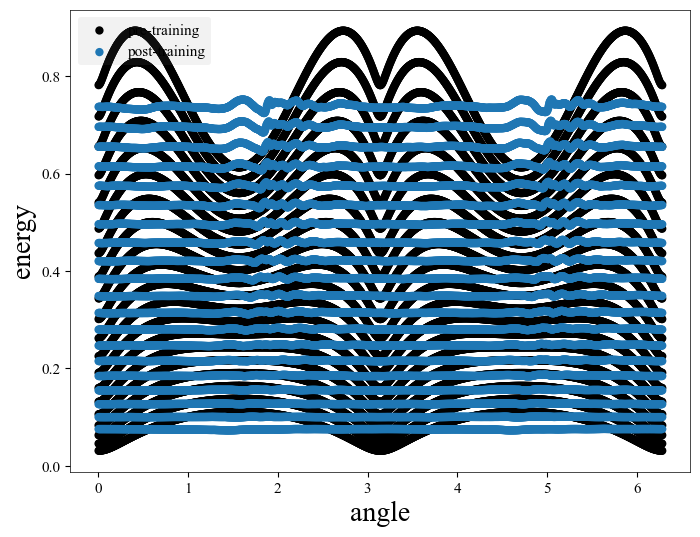

In [147]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

In [148]:
#aa0 = aa_guess[4][0].clone().requires_grad_()

In [184]:
ps0 = torch.tensor([1.2, 0], requires_grad=True).to(torch.float64)

In [185]:
H0 = H(ps0, model.targetPotential)
H0

tensor(0.5877, dtype=torch.float64, grad_fn=<AddBackward0>)

In [186]:
aa0 = model.ps_to_aa(ps0)
aa0

tensor([0.2737, 0.5584], dtype=torch.float64, grad_fn=<StackBackward0>)

In [187]:
from orbitflows.integrate import hamiltonian_fixed_angle, eulerstep

In [188]:
from functools import partial 
h_fixed_angle = partial(hamiltonian_fixed_angle, theta_set=torch.tensor(0.0))#theta_set[0])

In [189]:
euler_steps = 20
t_end = 10#10#2 * np.pi
dt = t_end / euler_steps
st = time()
aa_euler_step = model.integrate(aa0, euler_steps, t_end, hamiltonian_tilde=h_fixed_angle, correction=eulerstep).to(torch.float64)
euler_duration = time() - st

100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


In [190]:
from orbitflows.integrate import rungekutta4 as rk4

In [191]:
rk4_steps = int(euler_steps)
st = time()
aa_rk4 = model.integrate(aa0, rk4_steps, t_end, correction=rk4, hamiltonian_tilde=h_fixed_angle).to(torch.float64)
duration_rk4 = time() - st

100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


In [192]:
model.hamiltonian(aa_euler_step).detach()

tensor([0.5885, 0.5875, 0.5916, 0.5795, 0.6748, 0.7284, 0.7179, 0.7243, 0.7277,
        0.7302, 0.7313, 0.7289, 0.7385, 0.7442, 0.7738, 0.7734, 0.7673, 0.7697,
        0.7734, 0.7780], dtype=torch.float64)

In [193]:
model.hamiltonian(aa_euler_step.to(torch.float64)).detach()

tensor([0.5885, 0.5875, 0.5916, 0.5795, 0.6748, 0.7284, 0.7179, 0.7243, 0.7277,
        0.7302, 0.7313, 0.7289, 0.7385, 0.7442, 0.7738, 0.7734, 0.7673, 0.7697,
        0.7734, 0.7780], dtype=torch.float64)

<>:5: SyntaxWarning: invalid escape sequence '\s'

<>:6: SyntaxWarning: invalid escape sequence '\s'

<>:5: SyntaxWarning: invalid escape sequence '\s'

<>:6: SyntaxWarning: invalid escape sequence '\s'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4033769152.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4033769152.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(np.linspace(0, t_end, euler_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/euler_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4033769152.py:1: Depreca

Text(0.5, 1.0, 'Well trained model, large steps')

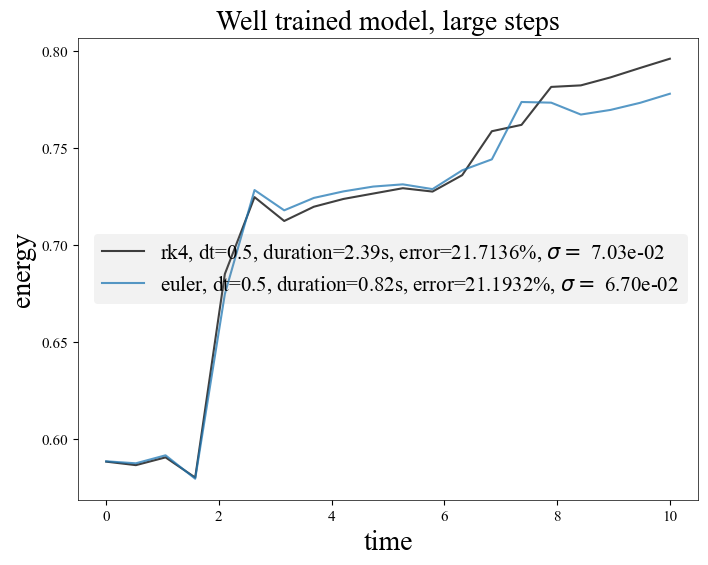

In [194]:
euler_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_euler_step).detach() - H0.detach()) /  H0.detach()).numpy())
euler_std = np.std(model.hamiltonian(aa_euler_step).detach().numpy())
rk4_percent_error = np.mean(100 * (np.abs(model.hamiltonian(aa_rk4).detach() - H0.detach()) /H0.detach()).numpy())
rk4_std = np.std(model.hamiltonian(aa_rk4).detach().numpy())
plt.plot(np.linspace(0, t_end, rk4_steps), model.hamiltonian(aa_rk4).detach(), label=f'rk4, dt={t_end/rk4_steps}, duration={duration_rk4:.2f}s, error={rk4_percent_error:.4f}%, $\sigma =$ {rk4_std:.2e}', alpha=0.75)
plt.plot(np.linspace(0, t_end, euler_steps), model.hamiltonian(aa_euler_step).detach(), label=f'euler, dt={t_end/euler_steps}, duration={euler_duration:.2f}s, error={euler_percent_error:.4f}%, $\sigma =$ {euler_std:.2e}', alpha=0.75)
plt.legend(fontsize=15)

plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.title('Well trained model, large steps', fontsize=20)

## compared to actionAngleVertical and numerical integration

### numerical integration

In [195]:
from galpy.orbit import Orbit
from galpy.potential import IsothermalDiskPotential
o_lf = Orbit(ps0.detach().numpy())
st = time()
lf_steps = 40
o_lf.integrate(np.linspace(0, t_end, lf_steps), pot=IsothermalDiskPotential(), method='leapfrog')
duration_lf = time() - st

### aAVI

In [196]:
from galpy.actionAngle import actionAngleVerticalInverse, actionAngleVertical
from galpy.potential import IsothermalDiskPotential

In [197]:
aAV = actionAngleVertical(pot=IsothermalDiskPotential())
j0, _, theta0 = aAV.actionsFreqsAngles(float(ps0.detach()[0]),float(ps0.detach()[1]))

In [198]:
# aAVI = actionAngleVerticalInverse(pot=IsothermalDiskPotential(), Es=np.linspace(0, 1, 1000), setup_interp=True)
# st = time()
# q_aAVI, p_aAVI = aAVI(j0, aa_guess[0][..., 0].detach().numpy())
# duration_aAVI = time() - st

In [199]:
#ps_aAVI = torch.stack([torch.tensor(q_aAVI), torch.tensor(p_aAVI)], dim=-1)

Text(0.5, 1.0, 'Poorly trained model, large steps')

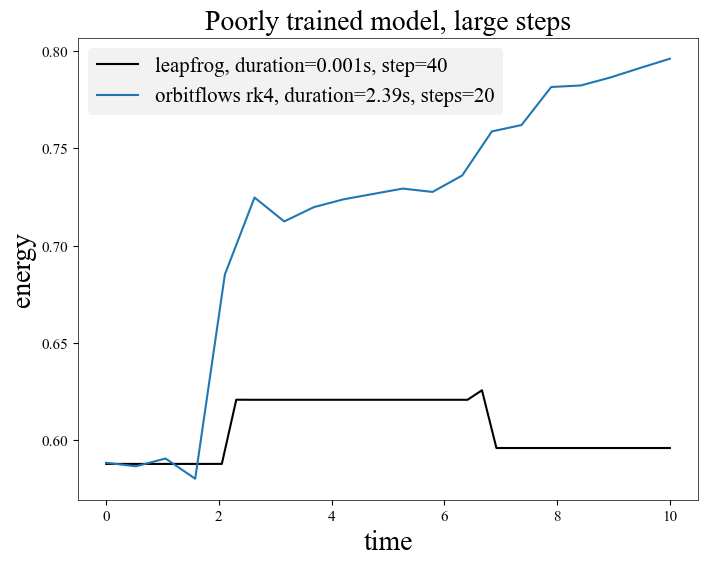

In [200]:
plt.plot(o_lf.time(), o_lf.E(o_lf.time()), label=f'leapfrog, duration={duration_lf:.3f}s, step={lf_steps}')
#plt.plot(np.linspace(0, t_end, len(ps_aAVI)), H(ps_aAVI, isoDiskPotential), label=f'aAVI, duration={duration_aAVI:.2f}s, steps={len(ps_aAVI)}')
plt.plot(np.linspace(0, t_end, len(aa_rk4)), model.hamiltonian(aa_rk4).detach(), label=f'orbitflows rk4, duration={duration_rk4:.2f}s, steps={rk4_steps}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(fontsize=15)
plt.title('Poorly trained model, large steps', fontsize=20)

In [201]:
from galpy.actionAngle import actionAngleVerticalInverse, actionAngleVertical
from galpy.potential import IsothermalDiskPotential

aAVI = actionAngleVerticalInverse(pot=IsothermalDiskPotential(), Es=np.linspace(0, 1, 1000), setup_interp=True)

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/actionAngle/actionAngleVerticalInverse.py:1257: RuntimeWarning: invalid value encountered in divide
  x = xmax * polynomial.polyval((xa / ptxmax).T, ptcoeffs.T, tensor=False).T

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/actionAngle/actionAngleVerticalInverse.py:1262: RuntimeWarning: invalid value encountered in divide
  xmax

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/actionAngle/actionAngleVerticalInverse.py:1264: RuntimeWarning: invalid value encountered in divide
  * polynomial.polyval((xa / ptxmax).T, ptderivcoeffs.T, tensor=False).T

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/actionAngle/actionAngleVerticalInverse.py:1379: RuntimeWarning: invalid value encountered in divide
  x = xmax * polynomial.polyval((xa / ptxmax).T, ptcoeffs.T, tensor=False).T

/opt/anaconda3/envs/MLDyn/lib/python3.12/site-packages/galpy/actionAngle/actionAngleVerticalInverse.py:1383: RuntimeWa

In [202]:
ps_ls = []
for aa_guess_i in aa_guess:
    ps_ls.append(aAVI(aa_guess_i[...,1].detach().numpy(), aa_guess_i[..., 0].detach().numpy()))
ps_ls = np.array(ps_ls)

# H_err grid

In [203]:
from orbitflows.integrate import hamiltonian_fixed_angle

In [204]:
def h_error(model, ps):
    '''
    Compute the error of the model prediction in the Hamiltonian.
    
    Parameters
    ----------
    ps : torch.tensor
        phase-space point
    
    Returns
    -------
    torch.tensor
        Hamiltonian error of the model prediction
    '''
    _aa = model.ps_to_aa(ps)
    return H(ps, model.targetPotential) - h_fixed_angle(model, _aa)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4116002123.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4116002123.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/4116002123.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


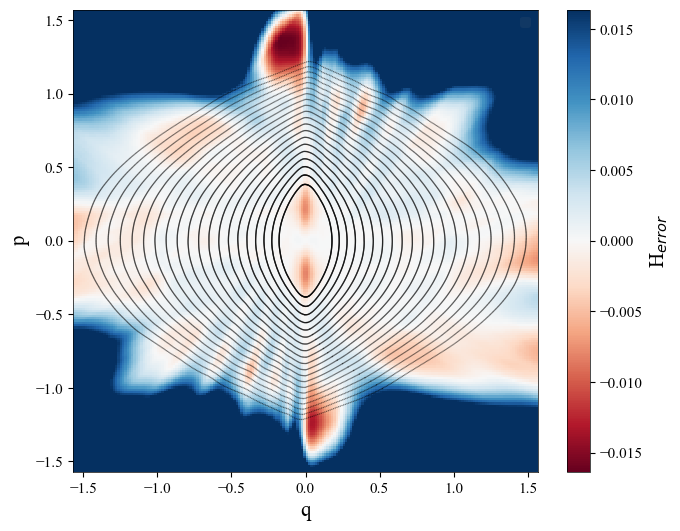

In [205]:
# Determine the range for q (x) and p (vx) from training data
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 200 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
# Shape: (n_grid_points*n_grid_points, 2)
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1)

# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])
# Batch processing if memory is an issue, but for 100x100 it should be fine
with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(model, ps_grid.to(torch.float64))

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), error_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)
pcm.set_clim(vmin=error_grid.min().item(), vmax=-error_grid.min().item())

# plt.plot(model.aa_to_ps(aa_guess)[0, :, 0].detach().numpy(),
#          model.aa_to_ps(aa_guess)[0, :, 1].detach().numpy(),
#          'w', alpha=0.5, label='NF Transformed Training Set)', lw=2)
# plt.plot(model.aa_to_ps(aa_guess)[1, :, 0].detach().numpy(),
#          model.aa_to_ps(aa_guess)[1, :, 1].detach().numpy(),
#          'w', alpha=0.5, lw=2)

# plt.plot(ps_ls[0,0].T, ps_ls[0,1].T, 
#         'w', alpha=0.5, label='Correctly Transformed Training Set (aAVI)', lw=2, linestyle='dashed')
# plt.plot(ps_ls[1,0].T, ps_ls[1,1].T, 
#         'w', alpha=0.5, lw=2, linestyle='dashed')
#plt.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(), model.aa_to_ps(aa_guess)[..., 1].detach().numpy(), c='k', alpha=0.5, s=1)
plt.legend(fontsize=10)
#plt.plot(*model.aa_to_ps(aa_guess).T.detach().numpy(), 'k', alpha=0.2)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
#plt.axis('equal') # Keep aspect ratio for phase space
plt.show()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3320271826.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3320271826.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



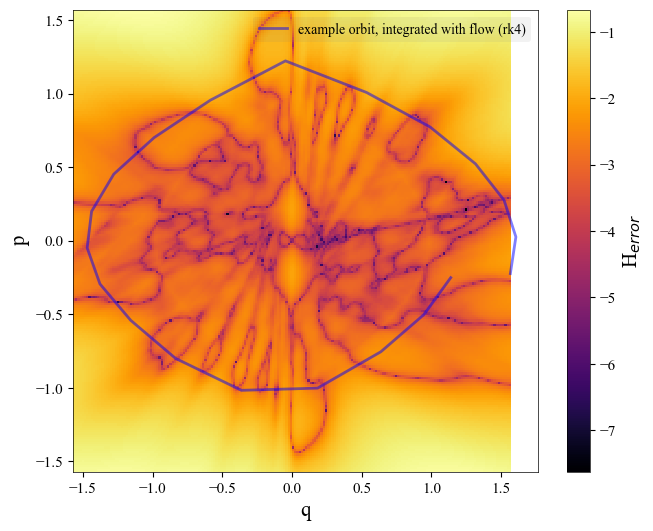

In [ ]:
# Determine the range for q (x) and p (vx) from training data
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 200 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
# Shape: (n_grid_points*n_grid_points, 2)
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1).to(torch.float64)

# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])
# Batch processing if memory is an issue, but for 100x100 it should be fine

with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(model, ps_grid)

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))

pcm = plt.pcolormesh(X.numpy(), VX.numpy(), np.log10(np.abs(error_grid.numpy())), cmap='inferno', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)


# plt.plot(model.aa_to_ps(aa_guess)[0, :, 0].detach().numpy(),
#          model.aa_to_ps(aa_guess)[0, :, 1].detach().numpy(),
#          'w', alpha=0.5, label='NF Transformed Training Set', lw=2)
# plt.plot(model.aa_to_ps(aa_guess)[1, :, 0].detach().numpy(),
#          model.aa_to_ps(aa_guess)[1, :, 1].detach().numpy(),
#          'w', alpha=0.5, lw=2)

# plt.plot(ps_ls[0,0].T, ps_ls[0,1].T, 
#         'w', alpha=0.5, label='Correctly Transformed Training Set (aAVI)', lw=2, linestyle='dashed')
# plt.plot(ps_ls[1,0].T, ps_ls[1,1].T, 
#         'w', alpha=0.5, lw=2, linestyle='dashed')

        
aa0_list = torch.tensor(np.array([aa_guess[0][...,0].detach(), aa0[1].repeat(len(aa_guess[0][...,0])).detach()]).T)
#plt.plot(*model.aa_to_ps(aa0_list).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, transformed')
plt.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=2)
#plt.plot(*training_data.T, 'r', alpha=0.5, label='training data')
# plt.plot(ps_ls[:,0].T, ps_ls[:,1].T, lw=1, label='correct orbits (aAVI)', c='w', linestyle='dashed', alpha=0.5)


plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
#plt.axis('equal') # Keep aspect ratio for phase space
plt.show()

In [117]:
def freq_tilde(model, aa):
    '''
    Compute the frequency of the system using the hamiltonian_tilde function.
    
    Parameters
    ----------
    aa : torch.tensor
        action-angle variables

    Returns
    -------
    torch.tensor
        frequency of the system assuming the hamiltonian_tilde function
    '''
    theta, j = aa[..., 0], aa[..., 1]
    _aa = torch.stack((theta, j), dim=-1)
    return torch.autograd.grad(h_fixed_angle(model, _aa), j, allow_unused=True)[0]

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3618736724.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3618736724.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3618736724.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


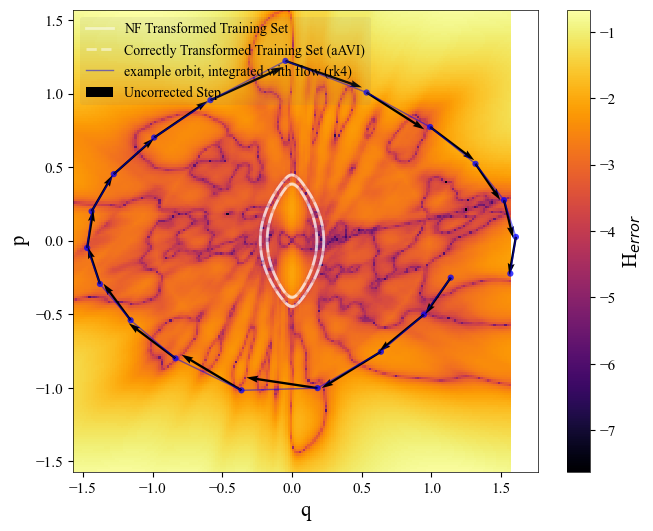

In [207]:
# Determine the range for q (x) and p (vx) from training data
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 200 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
# Shape: (n_grid_points*n_grid_points, 2)
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1).to(torch.float64)

# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])
# Batch processing if memory is an issue, but for 100x100 it should be fine

with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(model, ps_grid)

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))

pcm = plt.pcolormesh(X.numpy(), VX.numpy(), np.log10(np.abs(error_grid.numpy())), cmap='inferno', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)


plt.plot(model.aa_to_ps(aa_guess)[0, :, 0].detach().numpy(),
         model.aa_to_ps(aa_guess)[0, :, 1].detach().numpy(),
         'w', alpha=0.5, label='NF Transformed Training Set', lw=2)
plt.plot(model.aa_to_ps(aa_guess)[1, :, 0].detach().numpy(),
         model.aa_to_ps(aa_guess)[1, :, 1].detach().numpy(),
         'w', alpha=0.5, lw=2)

plt.plot(ps_ls[0,0].T, ps_ls[0,1].T, 
        'w', alpha=0.5, label='Correctly Transformed Training Set (aAVI)', lw=2, linestyle='dashed')
plt.plot(ps_ls[1,0].T, ps_ls[1,1].T, 
        'w', alpha=0.5, lw=2, linestyle='dashed')

        
aa0_list = torch.tensor(np.array([aa_guess[0][...,0].detach(), aa0[1].repeat(len(aa_guess[0][...,0])).detach()]).T)
#plt.plot(*model.aa_to_ps(aa0_list).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, transformed')
plt.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
plt.scatter(*model.aa_to_ps(aa_rk4).T.detach().numpy(), c='b', alpha=0.75, s=20)

freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in aa_rk4]).to(torch.float64) # Shape (n_steps, 2)
aa_rk4_guess = aa_rk4.clone().detach() # Shape (n_steps, 2)
aa_rk4_guess[...,0] = aa_rk4[..., 0] +  torch.tensor(freq_tildes) * dt
nf_prediction_ps = model.aa_to_ps(aa_rk4_guess.to(torch.float64)) # Shape (n_steps, 2)
q_plot_quiver = model.aa_to_ps(aa_rk4)[..., 0]
p_plot_quiver = model.aa_to_ps(aa_rk4)[..., 1]
delta_q_guess = nf_prediction_ps[..., 0] - q_plot_quiver
delta_p_guess = nf_prediction_ps[..., 1] - p_plot_quiver

plt.quiver(q_plot_quiver[:-1].detach().numpy(), p_plot_quiver[:-1].detach().numpy(),
           delta_q_guess.detach().numpy()[:-1], delta_p_guess.detach().numpy()[:-1],
           angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=1,
           label=f'Uncorrected Step')

plt.legend(fontsize=10, loc='upper left')
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
#plt.axis('equal') # Keep aspect ratio for phase space
plt.show()

In [ ]:
from orbitflows.integrate.correction import dH_dx
from tqdm import tqdm


In [211]:
scaling = 1.25
x_min, x_max = training_data[..., 0].min().item() * scaling, training_data[..., 0].max().item() * scaling
vx_min, vx_max = training_data[..., 1].min().item() * scaling, training_data[..., 1].max().item() * scaling

# Create a grid of points in phase space
n_grid_points = 100 # Number of points for each dimension in the grid
x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()
vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()
x_grid = torch.linspace(-x_minmax, x_minmax, n_grid_points)
vx_grid = torch.linspace(-vx_minmax, vx_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1).to(torch.float64)

# dH_dq_grid = []
# dH_dp_grid = []
# for ps_ in tqdm(ps_grid.requires_grad_()):
#     dH_dq_grid.append(dH_dx(ps_, 'q', partial(h_error, model)))
#     dH_dp_grid.append(dH_dx(ps_, 'p', partial(h_error, model)))


/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3820905413.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_minmax = torch.tensor(torch.abs(torch.tensor([x_min, x_max]))).max().item()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3820905413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vx_minmax = torch.tensor(torch.abs(torch.tensor([vx_min, vx_max]))).max().item()



In [212]:
# Reshape error_values to the grid shape
dH_dq_grid = torch.tensor(dH_dq_grid).reshape(n_grid_points, n_grid_points)
dH_dp_grid = torch.tensor(dH_dp_grid).reshape(n_grid_points, n_grid_points)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1049041126.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dH_dq_grid = torch.tensor(dH_dq_grid).reshape(n_grid_points, n_grid_points)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1049041126.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dH_dp_grid = torch.tensor(dH_dp_grid).reshape(n_grid_points, n_grid_points)



TypeError: scatter() got multiple values for argument 's'

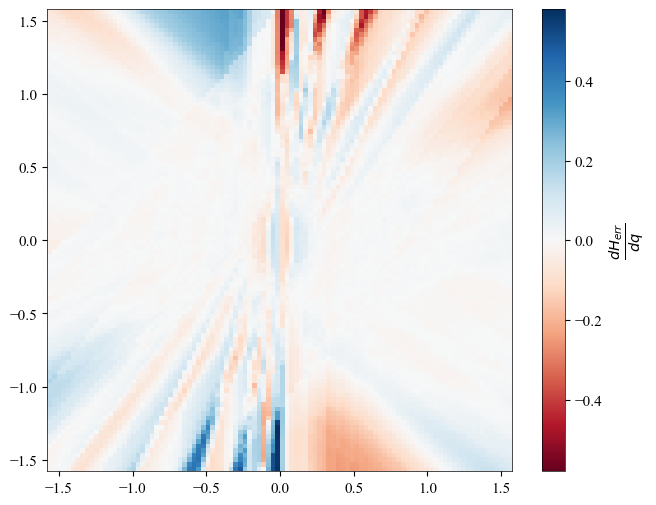

In [213]:

# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), dH_dq_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('$\\frac{dH_{err}}{dq}$', fontsize=15)
pcm.set_clim(vmin=-dH_dq_grid.max().item(), vmax=dH_dq_grid.max().item())

plt.scatter(model.aa_to_ps(aa_guess)[0, :, 0].detach().numpy(),
         model.aa_to_ps(aa_guess)[0, :, 1].detach().numpy(),
         'w', alpha=0.5, label='NF Transformed Training Set', s=2)
plt.plot(model.aa_to_ps(aa_guess)[1, :, 0].detach().numpy(),
         model.aa_to_ps(aa_guess)[1, :, 1].detach().numpy(),
         'w', alpha=0.5, lw=2)

plt.plot(ps_ls[0,0].T, ps_ls[0,1].T, 
        'w', alpha=0.5, label='Correctly Transformed Training Set (aAVI)', lw=2, linestyle='dashed')
plt.plot(ps_ls[1,0].T, ps_ls[1,1].T, 
        'w', alpha=0.5, lw=2, linestyle='dashed')
plt.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=2)

plt.legend(fontsize=10)
#plt.plot(*model.aa_to_ps(aa_guess).T.detach().numpy(), 'k', alpha=0.2)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.axis('equal') # Keep aspect ratio for phase space
plt.show()

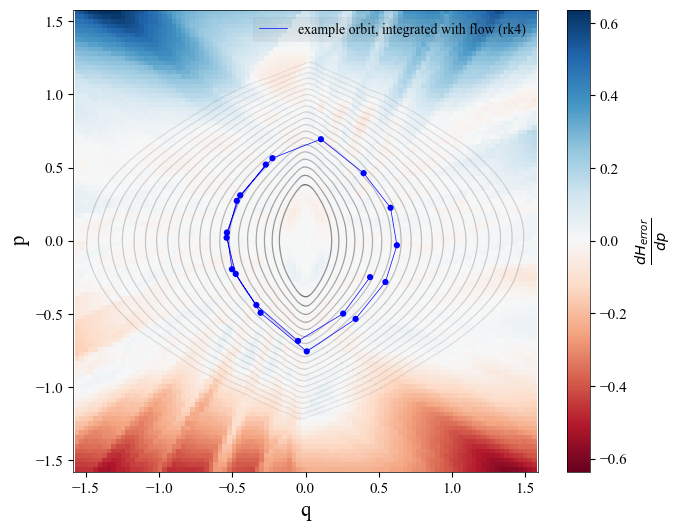

In [ ]:
# Plot the colormap
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(X.numpy(), VX.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('$\\frac{dH_{error}}{dp}$', fontsize=15)
pcm.set_clim(vmin=-dH_dp_grid.max().item(), vmax=dH_dp_grid.max().item())

plt.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(),
        model.aa_to_ps(aa_guess)[..., 1].detach().numpy(),
         c='k', alpha=0.1, s=1)
plt.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=1, label='example orbit, integrated with flow (rk4)', lw=0.5)
plt.scatter(*model.aa_to_ps(aa_rk4).T.detach().numpy(), c='b', alpha=1, s=20)

plt.legend(fontsize=10)
#plt.plot(*model.aa_to_ps(aa_guess).T.detach().numpy(), 'k', alpha=0.2)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.axis('equal') # Keep aspect ratio for phase space
plt.show()

In [214]:
aa_guesses = generate_sho_orbits(10, omega=omega_guess, t_end=2*np.pi, n_steps=100, r_bounds=[0.2,1.5])[1]
ps_ls_orbit_grid = []
for aa_guess_i in aa_guesses:
    ps_ls_orbit_grid.append(aAVI(aa_guess_i[...,1].detach().numpy(), aa_guess_i[..., 0].detach().numpy()))
ps_ls_orbit_grid = np.array(ps_ls_orbit_grid)

<>:5: SyntaxWarning: invalid escape sequence '\p'

<>:6: SyntaxWarning: invalid escape sequence '\p'

<>:5: SyntaxWarning: invalid escape sequence '\p'

<>:6: SyntaxWarning: invalid escape sequence '\p'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3359999680.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3359999680.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)



/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/3359999680.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_rk4_guess[...,0] = aa_rk4[..., 0] +  torch.tensor(freq_tildes) * dt



Text(-0.04, 1.2, 'Poorly Trained Model')

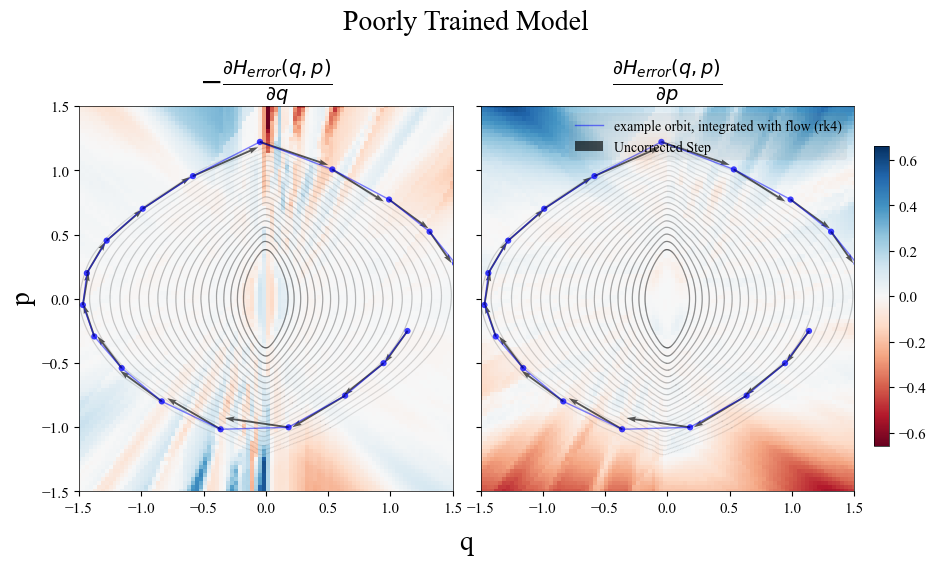

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.075})
pcm = ax[0].pcolormesh(X.numpy(), VX.numpy(), dH_dq_grid.numpy(), cmap='RdBu', shading='auto')
pcm2 = ax[1].pcolormesh(X.numpy(), VX.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')

ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)
ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)

cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
plt.colorbar(pcm, cax=cax)
minmax = torch.abs(torch.tensor([dH_dq_grid.max().item(), dH_dq_grid.min().item(), dH_dp_grid.max().item(), dH_dp_grid.min().item()])).max().item()
pcm.set_clim(vmin=-minmax, vmax=minmax)
pcm2.set_clim(vmin=-minmax, vmax=minmax)

freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in aa_rk4]).to(torch.float64) # Shape (n_steps, 2)
aa_rk4_guess = aa_rk4.clone().detach() # Shape (n_steps, 2)
aa_rk4_guess[...,0] = aa_rk4[..., 0] +  torch.tensor(freq_tildes) * dt
nf_prediction_ps = model.aa_to_ps(aa_rk4_guess.to(torch.float64)) # Shape (n_steps, 2)
q_plot_quiver = model.aa_to_ps(aa_rk4)[..., 0]
p_plot_quiver = model.aa_to_ps(aa_rk4)[..., 1]
delta_q_guess = nf_prediction_ps[..., 0] - q_plot_quiver
delta_p_guess = nf_prediction_ps[..., 1] - p_plot_quiver

ex_orb = aa0.repeat(len(aa_guess[0][...,0]), 1)
ex_orb[...,0] = aa_guess[0][...,0].detach()

for axi in ax:
    axi.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(),
        model.aa_to_ps(aa_guess)[..., 1].detach().numpy(),
         c='k', alpha=0.1, s=1)
    axi.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
    axi.scatter(*model.aa_to_ps(aa_rk4).T.detach().numpy(), c='b', alpha=0.75, s=20)
    axi.quiver(q_plot_quiver[:-1].detach().numpy(), p_plot_quiver[:-1].detach().numpy(),
            delta_q_guess.detach().numpy()[:-1], delta_p_guess.detach().numpy()[:-1],
            angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=0.65,
            label=f'Uncorrected Step')
    
ax[1].annotate('q', xy=(-0.04, -0.15), xycoords='axes fraction', ha='center', fontsize=20)
ax[0].annotate('p', xy=(-0.15, 0.5), xycoords='axes fraction', ha='center', fontsize=20, rotation='vertical')
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
ax[1].legend(fontsize=10, loc='upper right')
ax[1].annotate('Poorly Trained Model', xy=(-0.04, 1.2), xycoords='axes fraction', ha='center', fontsize=20)

<>:5: SyntaxWarning: invalid escape sequence '\p'

<>:6: SyntaxWarning: invalid escape sequence '\p'

<>:5: SyntaxWarning: invalid escape sequence '\p'

<>:6: SyntaxWarning: invalid escape sequence '\p'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1733187936.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1733187936.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_60292/1733187936.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_rk4_guess[...,0] = aa_rk4[..., 0] +  torch.tensor(freq_tildes) * dt



Text(-0.04, 1.2, 'Well Trained Model, large correction steps')

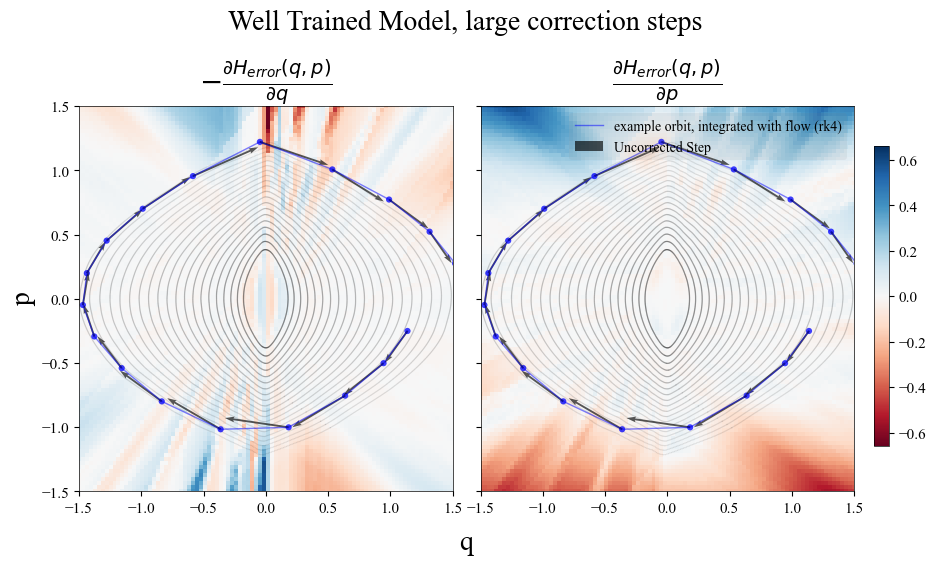

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.075})
pcm = ax[0].pcolormesh(X.numpy(), VX.numpy(), dH_dq_grid.numpy(), cmap='RdBu', shading='auto')
pcm2 = ax[1].pcolormesh(X.numpy(), VX.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')

ax[0].set_title('$- \\frac{\partial{H_{error}}(q,p)}{\partial q}$', fontsize=20)
ax[1].set_title('$\\frac{\partial{H_{error}}(q,p)}{\partial p}$', fontsize=20)

cax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
plt.colorbar(pcm, cax=cax)
minmax = torch.abs(torch.tensor([dH_dq_grid.max().item(), dH_dq_grid.min().item(), dH_dp_grid.max().item(), dH_dp_grid.min().item()])).max().item()
pcm.set_clim(vmin=-minmax, vmax=minmax)
pcm2.set_clim(vmin=-minmax, vmax=minmax)

freq_tildes = torch.tensor([freq_tilde(model, aa_) for aa_ in aa_rk4]).to(torch.float64) # Shape (n_steps, 2)
aa_rk4_guess = aa_rk4.clone().detach() # Shape (n_steps, 2)
aa_rk4_guess[...,0] = aa_rk4[..., 0] +  torch.tensor(freq_tildes) * dt
nf_prediction_ps = model.aa_to_ps(aa_rk4_guess.to(torch.float64)) # Shape (n_steps, 2)
q_plot_quiver = model.aa_to_ps(aa_rk4)[..., 0]
p_plot_quiver = model.aa_to_ps(aa_rk4)[..., 1]
delta_q_guess = nf_prediction_ps[..., 0] - q_plot_quiver
delta_p_guess = nf_prediction_ps[..., 1] - p_plot_quiver

ex_orb = aa0.repeat(len(aa_guess[0][...,0]), 1)
ex_orb[...,0] = aa_guess[0][...,0].detach()

for axi in ax:
    axi.scatter(model.aa_to_ps(aa_guess)[..., 0].detach().numpy(),
        model.aa_to_ps(aa_guess)[..., 1].detach().numpy(),
         c='k', alpha=0.1, s=1)
    axi.plot(*model.aa_to_ps(aa_rk4).T.detach().numpy(), 'b', alpha=0.5, label='example orbit, integrated with flow (rk4)', lw=1)
    axi.scatter(*model.aa_to_ps(aa_rk4).T.detach().numpy(), c='b', alpha=0.75, s=20)
    axi.quiver(q_plot_quiver[:-1].detach().numpy(), p_plot_quiver[:-1].detach().numpy(),
            delta_q_guess.detach().numpy()[:-1], delta_p_guess.detach().numpy()[:-1],
            angles='xy', scale_units='xy', scale=1, color='k', width=0.005, alpha=0.65,
            label=f'Uncorrected Step')
    
ax[1].annotate('q', xy=(-0.04, -0.15), xycoords='axes fraction', ha='center', fontsize=20)
ax[0].annotate('p', xy=(-0.15, 0.5), xycoords='axes fraction', ha='center', fontsize=20, rotation='vertical')
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
ax[1].legend(fontsize=10, loc='upper right')
ax[1].annotate('Well Trained Model, large correction steps', xy=(-0.04, 1.2), xycoords='axes fraction', ha='center', fontsize=20)